<a href="https://colab.research.google.com/github/Brunocs1991/google_colaboratory/blob/main/YOLO_v4_Detec%C3%A7%C3%A3o_de_objetos_com_OpenCV_Exmplorando_mais.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Detectando objetos com YOLO e OpenCV - Explorando mais opções

## Etapa 1 - importando as bibliotecas

In [1]:
import cv2
import numpy as np
import time
import matplotlib.pyplot as plt
from google.colab.patches import cv2_imshow
import zipfile
import os

## Etapa 2 - Conectando com o Google Drive

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Etapa 3 - Carregando os arquivos do modelo treinado

In [3]:
path = '/content/drive/MyDrive/Colab Notebooks/data/modelo_YOLOv4.zip'
zip_object = zipfile.ZipFile(file=path, mode='r')
zip_object.extractall('./')
zip_object.close()

In [4]:
labelsPath = os.path.sep.join(['cfg','coco.names'])
LABELS = open(labelsPath).read().strip().split('\n')

In [5]:
weightsPath = os.path.sep.join(['./', 'yolov4.weights'])
configPath = os.path.sep.join(['cfg','yolov4.cfg'])

In [6]:
net = cv2.dnn.readNet(configPath, weightsPath)

## Etapa 4 - Definindo mais configurações para a detecção

In [7]:
np.random.seed(42)
COLORS = np.random.randint(0, 255, size=(len(LABELS), 3), dtype='uint8')

In [8]:
ln = net.getLayerNames()
print("Todas as camadas (layers): ")
print(ln)
print(f'Total: {len(ln)}')
print("Camadas de sáida")
print(net.getUnconnectedOutLayers())
ln = [ln[i - 1] for i in net.getUnconnectedOutLayers()]
print(ln)

Todas as camadas (layers): 
('conv_0', 'bn_0', 'mish_1', 'conv_1', 'bn_1', 'mish_2', 'conv_2', 'bn_2', 'mish_3', 'identity_3', 'conv_4', 'bn_4', 'mish_5', 'conv_5', 'bn_5', 'mish_6', 'conv_6', 'bn_6', 'mish_7', 'shortcut_7', 'conv_8', 'bn_8', 'mish_9', 'concat_9', 'conv_10', 'bn_10', 'mish_11', 'conv_11', 'bn_11', 'mish_12', 'conv_12', 'bn_12', 'mish_13', 'identity_13', 'conv_14', 'bn_14', 'mish_15', 'conv_15', 'bn_15', 'mish_16', 'conv_16', 'bn_16', 'mish_17', 'shortcut_17', 'conv_18', 'bn_18', 'mish_19', 'conv_19', 'bn_19', 'mish_20', 'shortcut_20', 'conv_21', 'bn_21', 'mish_22', 'concat_22', 'conv_23', 'bn_23', 'mish_24', 'conv_24', 'bn_24', 'mish_25', 'conv_25', 'bn_25', 'mish_26', 'identity_26', 'conv_27', 'bn_27', 'mish_28', 'conv_28', 'bn_28', 'mish_29', 'conv_29', 'bn_29', 'mish_30', 'shortcut_30', 'conv_31', 'bn_31', 'mish_32', 'conv_32', 'bn_32', 'mish_33', 'shortcut_33', 'conv_34', 'bn_34', 'mish_35', 'conv_35', 'bn_35', 'mish_36', 'shortcut_36', 'conv_37', 'bn_37', 'mish_38

## Etapa 5 - Carregando a imagem onde será feita a detecção

In [9]:
def mostrar(img):
  fig = plt.gcf()
  fig.set_size_inches(16, 10)
  plt.axis('off')
  plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
  plt.show()

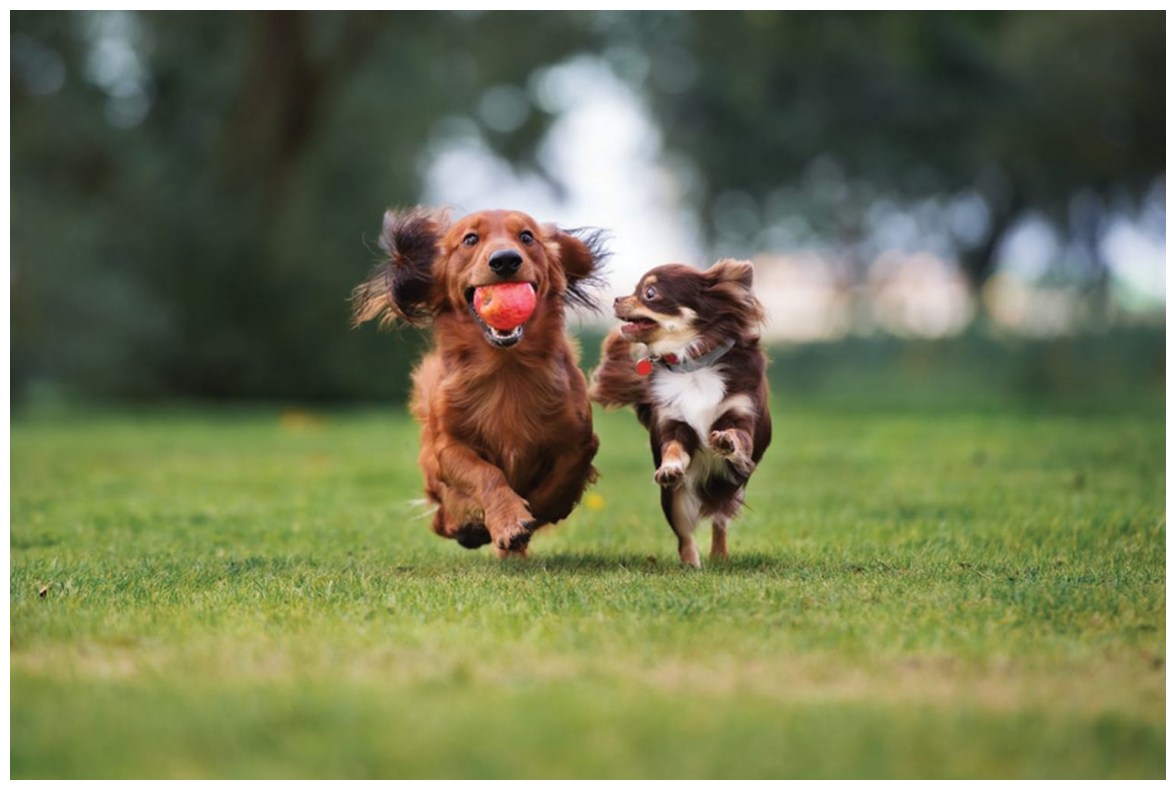

Altura: 1000 
Largura: 1500


In [10]:
imagem = cv2.imread("/content/drive/MyDrive/Colab Notebooks/data/cachorros02.jpg")
mostrar(imagem)
imagem_cp = imagem.copy()
(H, W) = imagem.shape[:2]
print(f'Altura: {H} \nLargura: {W}')

## Etapa 6 - Processando a imagem de entrada

### Redimensionamento da imagem (opcional)

In [11]:
def redimensionar(imagem, largura_maxima = 600):
  if imagem.shape[1] > largura_maxima:
    proporcao = imagem.shape[1] / imagem.shape[0]
    imagem_largura = largura_maxima
    imagem_altura = int(imagem_largura / proporcao)
  else:
    imagem_largura = imagem.shape[1]
    imagem_altura = imagem.shape[0]

  imagem = cv2.resize(imagem, (imagem_largura, imagem_altura))
  return  imagem

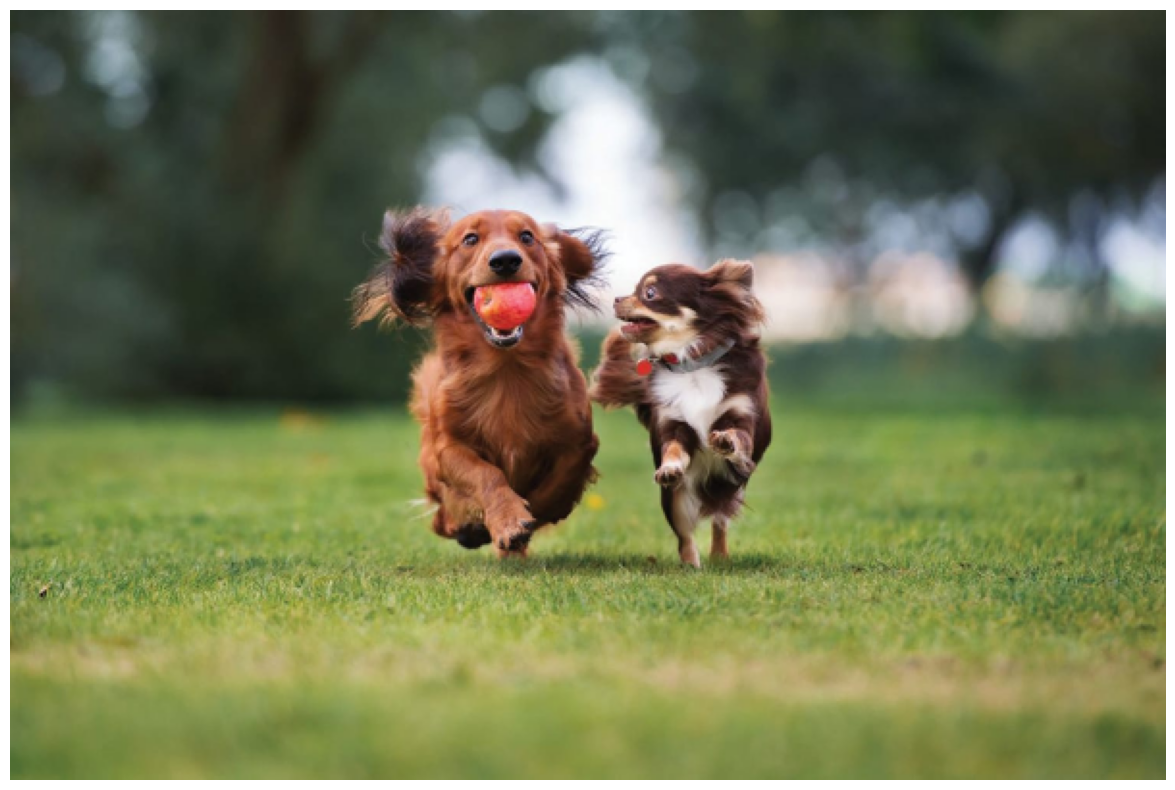

Altura: 400 
Largura: 600


In [12]:
imagem = redimensionar(imagem)
mostrar(imagem)
(H, W) = imagem.shape[:2]
imagem_cp = imagem.copy()
print(f'Altura: {H} \nLargura: {W}')

### Construindo o blob da imagem

In [13]:
def blob_imagem(net, imagem, mostrar_texto=True):
  inicio = time.time()

  blob = cv2.dnn.blobFromImage(imagem, 1 /255.0, (416, 416), swapRB=True, crop=False)
  net.setInput(blob)
  layerOutputs = net.forward(ln)

  termino = time.time()
  if mostrar_texto:
    print(f'YOLO levou {(termino - inicio):.2f} segundos')

  return net, imagem, layerOutputs

In [14]:
net, imagem, layerOutputs = blob_imagem(net, imagem)

YOLO levou 11.29 segundos


## Etapa 7 - Definindo as variáveis

In [15]:
_threshold = 0.5
_threshold_NMS = 0.3
caixas = []
confiancas = []
IDclasses = []

## Etapa 8 - Realizando a predição

In [16]:
def deteccoes(detection, _threshold, caixas, confiacas, IDclasses):
  scores = detection[5:]
  classeID = np.argmax(scores)
  confianca = scores[classeID]

  if(confianca > _threshold):
    caixa = detection[0:4] * np.array([W, H, W, H])
    (centerX, centerY, width, height) = caixa.astype("int")
    x = int(centerX - (width / 2))
    y = int(centerY - (height / 2))

    caixas.append([x, y, int(width), int(height)])
    confiacas.append(float(confianca))
    IDclasses.append(classeID)
  return caixas, confiacas, IDclasses

In [17]:
for output in layerOutputs:
  for detection in output:
    caixas, confiancas, IDclasses = deteccoes(detection, _threshold, caixas, confiancas, IDclasses)

In [18]:
print(caixas)
print(confiancas)
print(IDclasses)
len(caixas)

[[174, 101, 137, 185], [175, 102, 136, 184], [292, 130, 104, 162], [292, 129, 103, 163], [304, 128, 91, 164], [303, 129, 93, 164], [304, 128, 92, 164], [304, 137, 92, 157], [303, 137, 94, 157], [303, 137, 94, 158], [173, 103, 139, 180], [175, 102, 138, 181], [300, 129, 97, 159], [300, 128, 98, 162], [299, 134, 100, 164]]
[0.9698281288146973, 0.9766562581062317, 0.6564343571662903, 0.6459724307060242, 0.9790457487106323, 0.9852045774459839, 0.9846768975257874, 0.5124323964118958, 0.5628817081451416, 0.5340076684951782, 0.9917901754379272, 0.9916052222251892, 0.9891760945320129, 0.9827836751937866, 0.5568493604660034]
[16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16]


15

## Etapa 9 - Aplicando o Non-Maxima Supression

In [19]:
objs = cv2.dnn.NMSBoxes(caixas, confiancas, _threshold, _threshold_NMS)
print(f'Objetos detectados: {len(objs)}')

Objetos detectados: 2


## Etapa 10 - Mostrando o resultado da detecção na imagem

In [20]:
def check_nefativo(n):
  if(n < 0):
    return 0
  else:
    return n

def funcoes_imagem(imagem, i, confiancas, caixas, COLORS, LABELS, mostrar_texto=True):
  (x, y) = (caixas[i][0], caixas[i][1])
  (w, h) = (caixas[i][2], caixas[i][3])
  cor = [int(c) for c in COLORS[IDclasses[i]]]
  cv2.rectangle(imagem, (x, y), (x + w, y + h), cor, 2)
  texto = f'{LABELS[IDclasses[i]]}: {confiancas[i]:.4f}'
  if(mostrar_texto):
    print(f'> {texto}')
    print(x, y, w, h)
  cv2.putText(imagem, texto, (x, y -5), cv2.FONT_HERSHEY_SIMPLEX, 0.5, cor, 2)
  return imagem, x, y, w, h

> dog: 0.9918
173 103 139 180


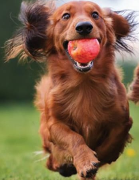

> dog: 0.9892
300 129 97 159


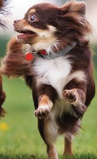

In [21]:
if len(objs) > 0:
  for i in objs:
    image, x, y, w, h = funcoes_imagem(imagem, i, confiancas, caixas, COLORS, LABELS)
    objeto = imagem_cp[y:y + h, x:x + w]
    cv2_imshow(objeto)

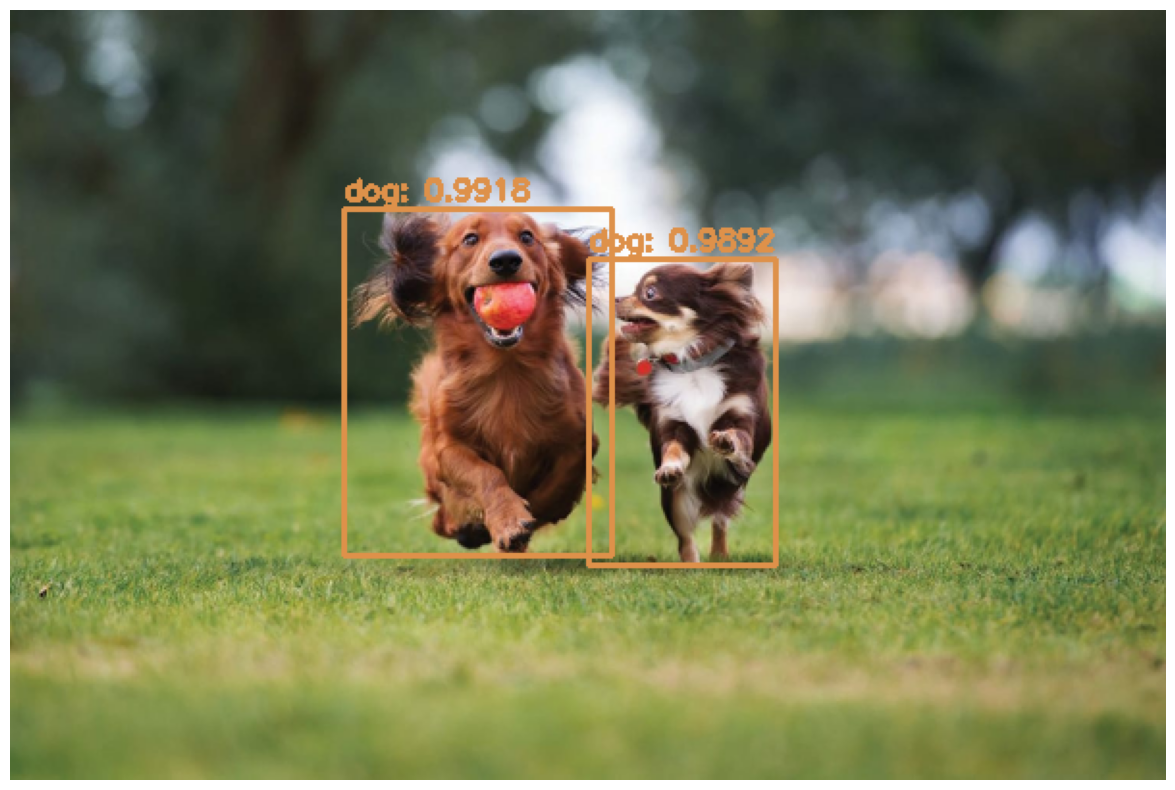

In [22]:
mostrar(imagem)